In [6]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ
import pandas as pd

logger = logging.getLogger()

In [7]:
@rf.block
class STDIn:
    filename: str
    out_ds: rf.Output[typ.Any]

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        logger.info(df.shape)
        self.out_ds.put(df)


@rf.block
class STDOut:
    in_ds: typ.Any
    out_filename: str

    def run(self):
        logger.info(self.in_ds.shape)
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
            

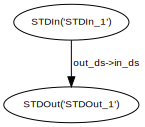

In [8]:
config = {'cores': 1, 'ram': 4096}

size = '10MB'
ip_filename = "/data/sdk_testbench/input_data/dummy_"+size+"_df.parquet"
op_filename = "/data/sdk_testbench/output_data/tc_03.parquet"

std_in = STDIn(filename=ip_filename)
std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
std_in.out_ds = rf.Output.set(transport=rf.FileTransport)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='atomic_file_transport', targets=[std_out])
pipeline.show()

In [9]:
def create_pipeline():
    return pipeline

In [10]:
prun = razor.api.engines('DS-engine').execute(pipeline)